In [1]:
import sys
sys.path.insert(0, "../") # am ashame

import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import yaml

import npm_utils as npm
from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
base_path = "../"
with open(os.path.join(base_path, npm.CONFIG_PATH), "r") as fp:
    config = yaml.load(fp)
config

{'data_path': 'data/rv-all-subset-1e4.fits',
 'kdtree_label_names': ['bp_rp', 'absolute_rp_mag', 'phot_rp_mean_mag'],
 'kdtree_minimum_points': 128,
 'kdtree_minimum_radius': [0.05, 0.25, 0.25],
 'kdtree_relative_scales': [0.1, 1.0, 1.0],
 'model_path': 'npm.stan',
 'optimisation_kwds': {'iter': 10000,
  'tol_grad': '1e-15',
  'tol_obj': '1e-15',
  'tol_rel_grad': '1e3',
  'tol_rel_obj': '1e4',
  'verbose': False},
 'predictor_label_names': ['rv_single_epoch_scatter'],
 'results_path': 'results/',
 'results_suffix': None,
 'share_optimised_result_with_nearest': 32}

In [3]:
# Relevant configuration keywords:
#   kdtree_label_names     - label names to use to construct the KD tree
#   kdtree_relative_scales - scale the dimensions when constructing the KD tree
#   kdtree_minimum_points  - minimum number of points to have when querying the KD tree
#   kdtree_minimum_radius  - minimum ball radius (in each dimension) when querying the KD tree


In [4]:
from astropy.io import fits
data = fits.open(os.path.join(base_path, config["data_path"]))[1].data

In [5]:
X = np.vstack([data[ln] for ln in config["kdtree_label_names"]]).T
predictors = np.vstack([data[ln] for ln in config["predictor_label_names"]]).T

finite = np.where(np.all(np.isfinite(X), axis=1))[0]

X = X[finite]
predictors = predictors[finite]

N, D = X.shape

kdt, scale, offset = npm.build_kdtree(
    X, relative_scales=config.get("kdtree_relative_scales", None))

query_kwds = dict(offset=offset, scale=scale, full_output=False,
                  minimum_points=config.get("kdtree_minimum_points", 1024),
                  minimum_radius=config.get("kdtree_minimum_radius", None))
print(query_kwds)

{'offset': array([ 1.03375229,  2.53939978, 11.16616161]), 'scale': [0.1, 1.0, 1.0], 'full_output': False, 'minimum_points': 128, 'minimum_radius': [0.05, 0.25, 0.25]}


Text(0,0.5,'\\textrm{absolute rp mag}')

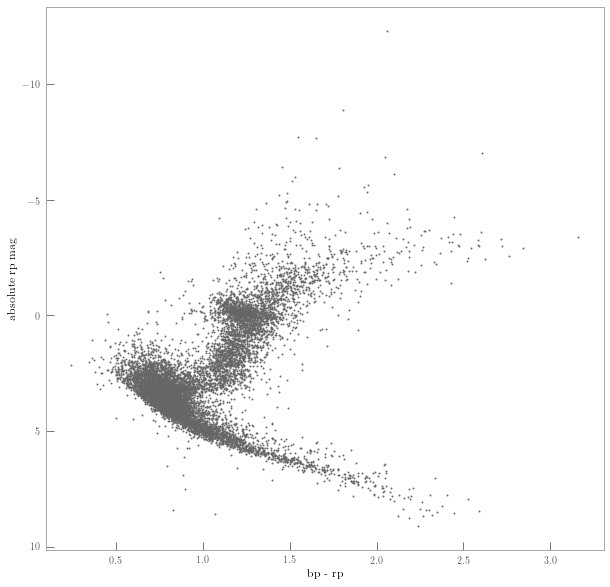

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X.T[0], X.T[1], s=1, c="#666666", alpha=0.9)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel(r"\textrm{bp - rp}")
ax.set_ylabel(r"\textrm{absolute rp mag}")

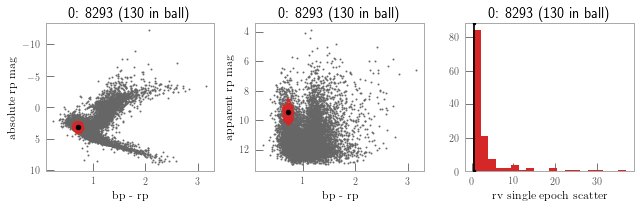

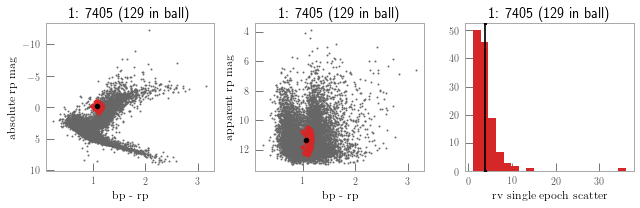

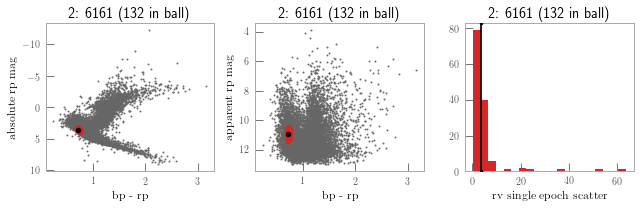

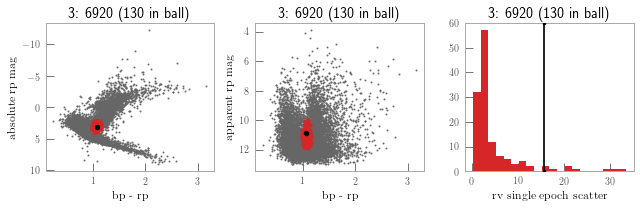

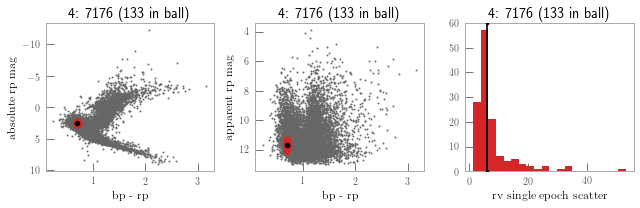

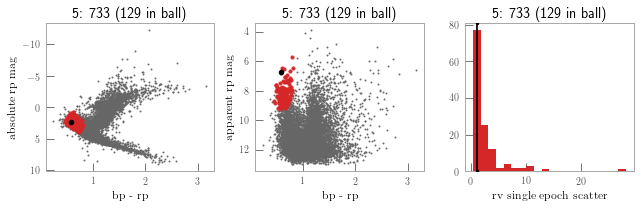

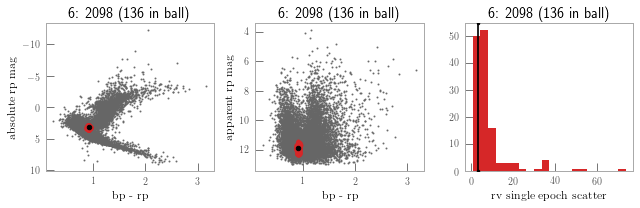

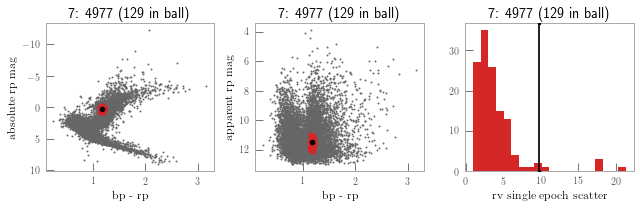

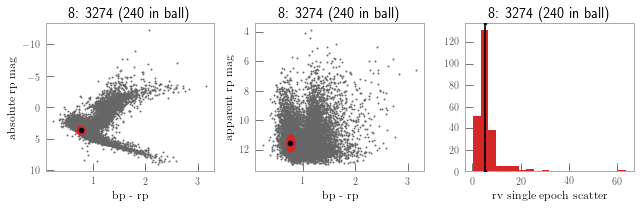

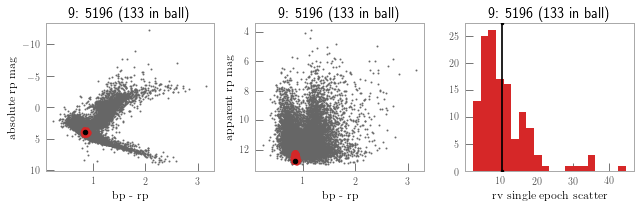

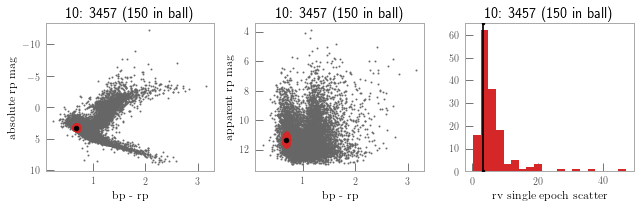

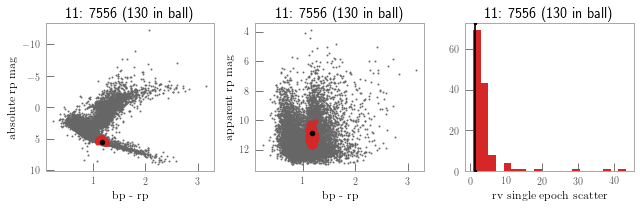

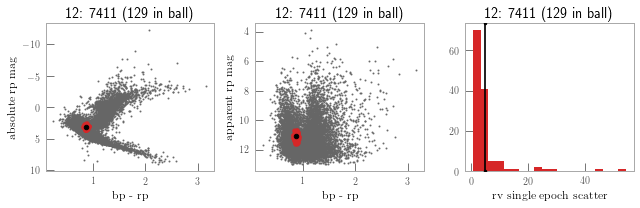

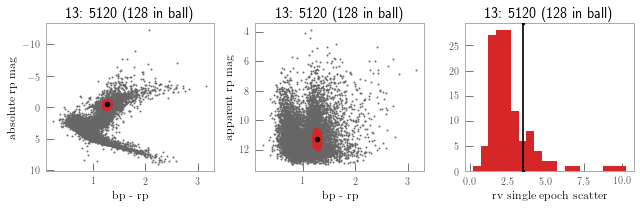

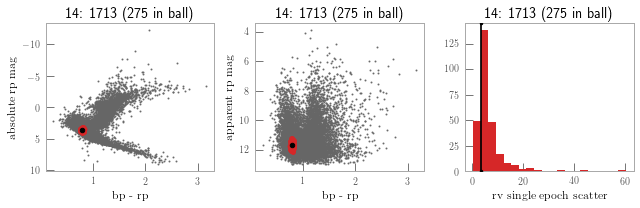

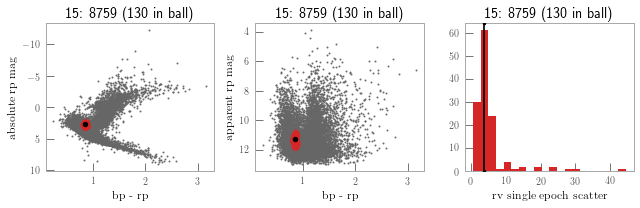

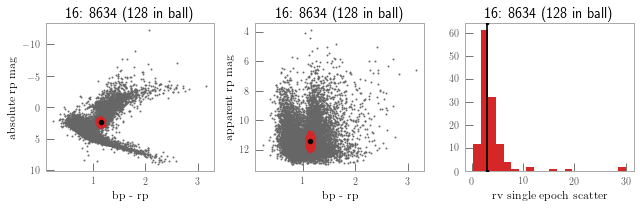

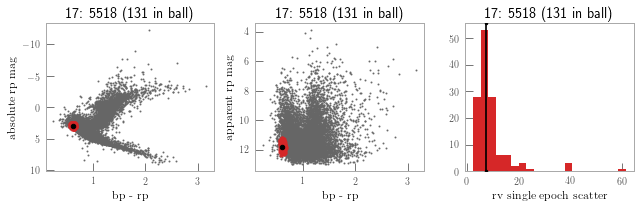

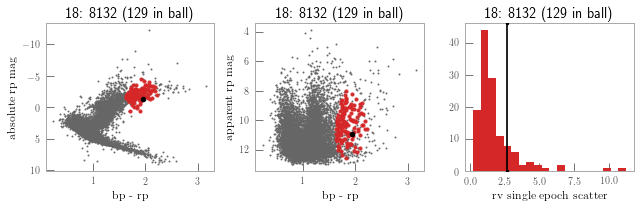

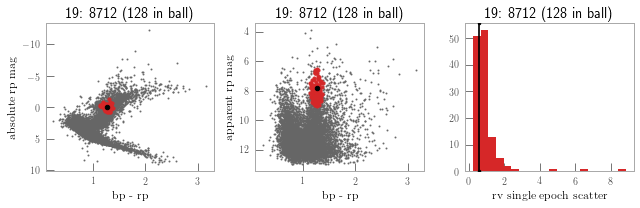

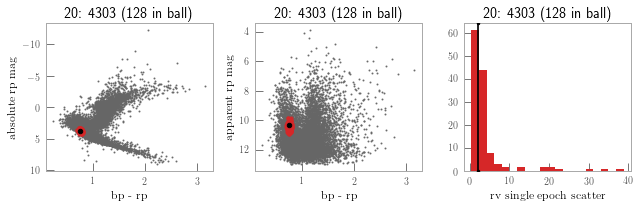

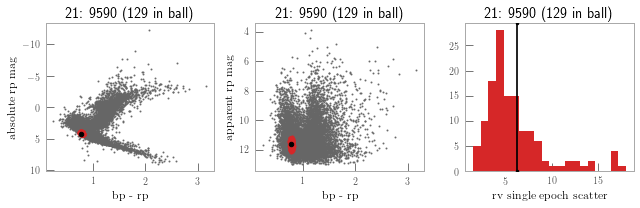

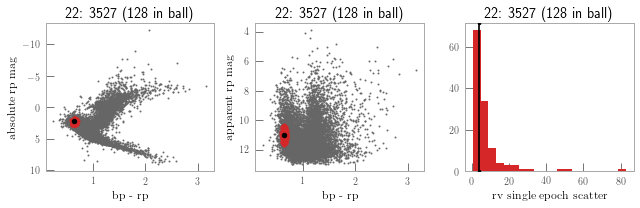

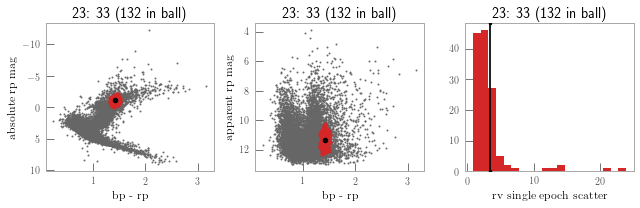

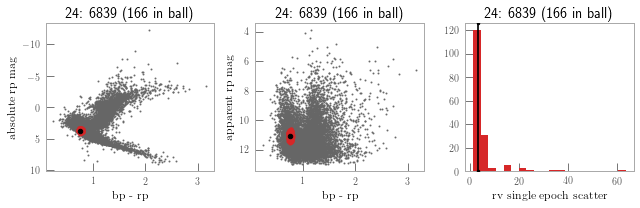

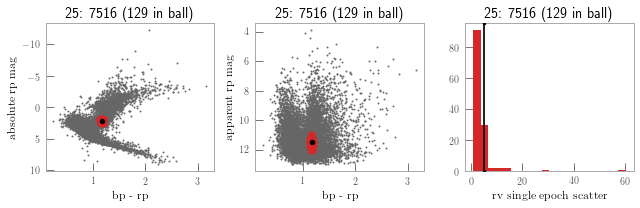

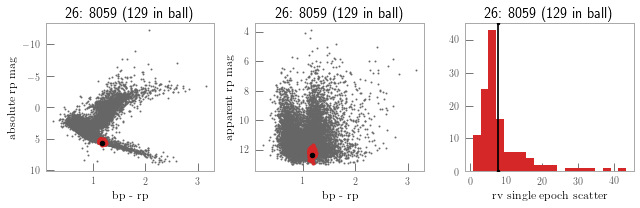

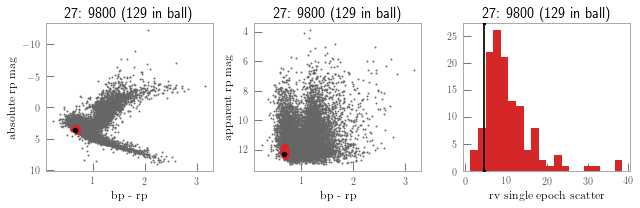

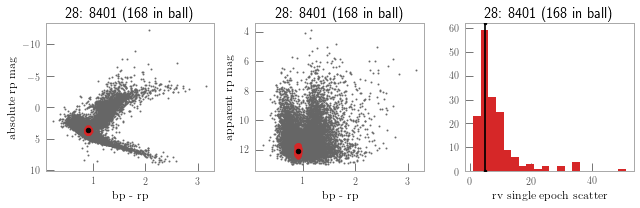

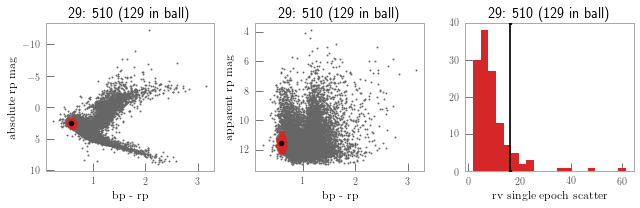

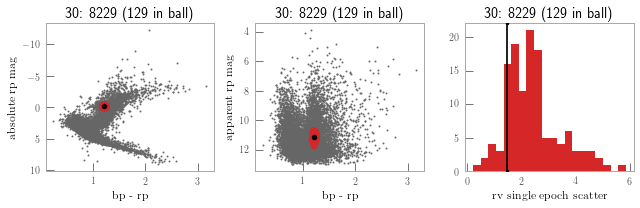

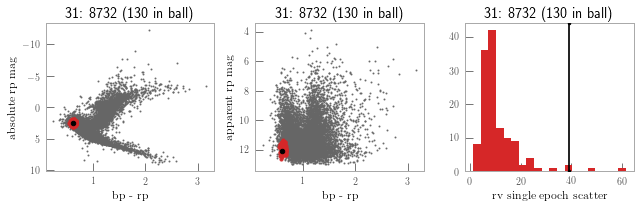

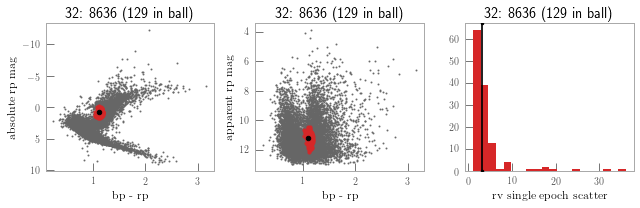

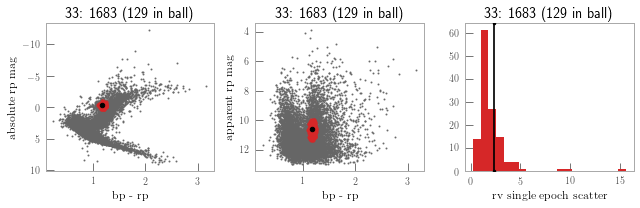

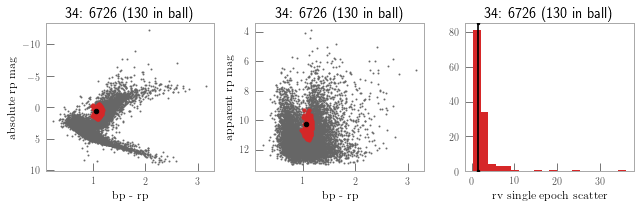

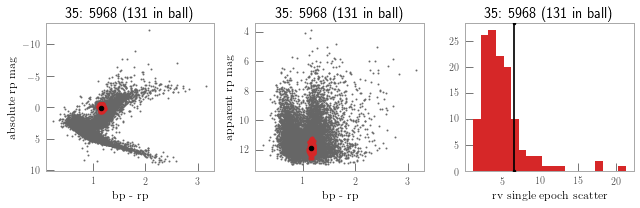

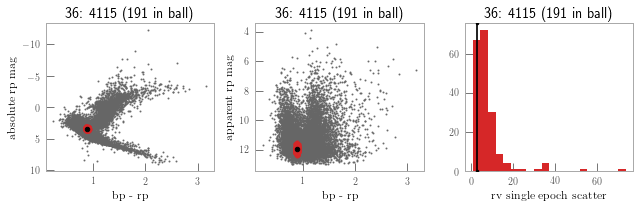

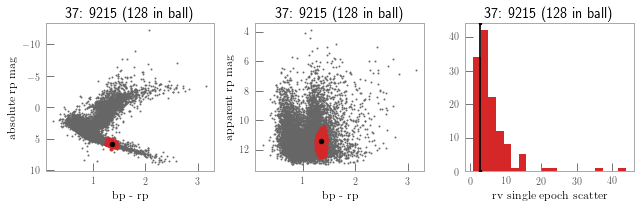

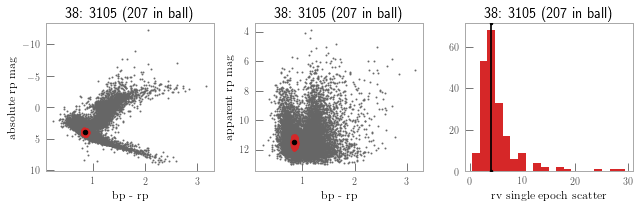

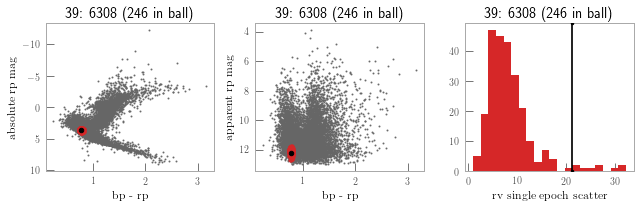

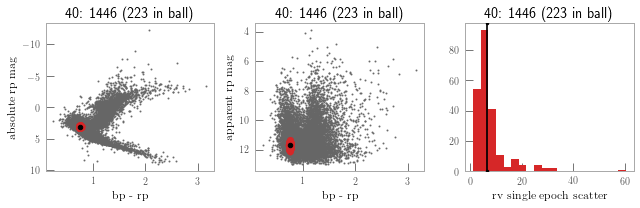

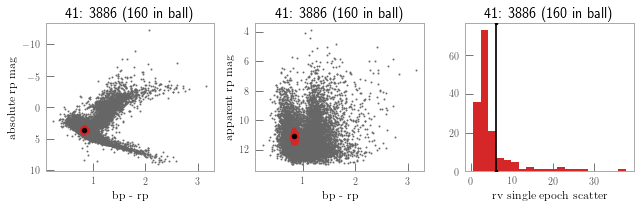

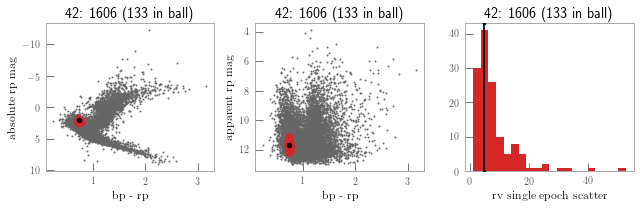

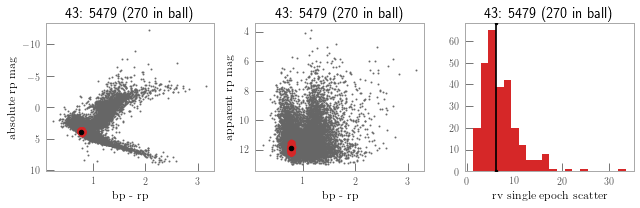

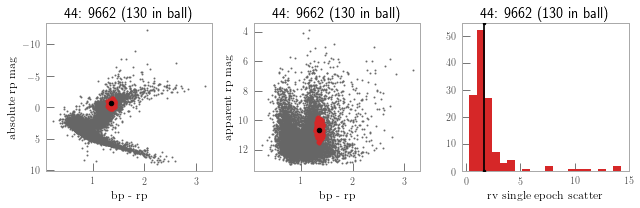

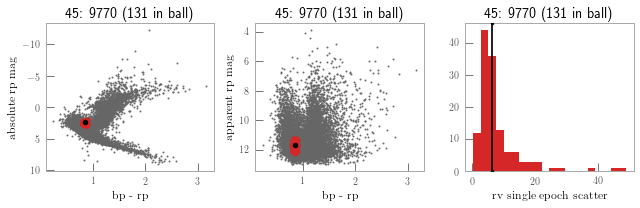

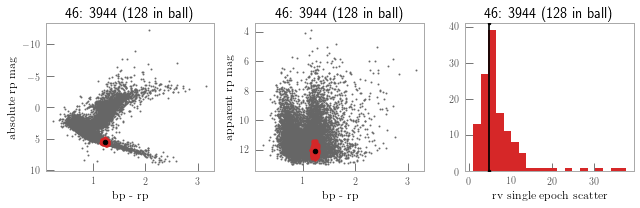

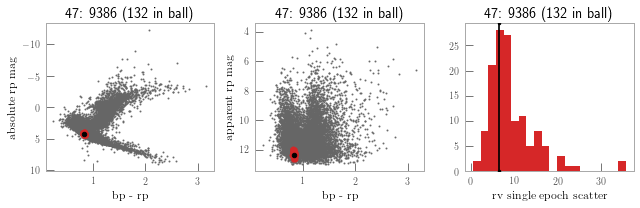

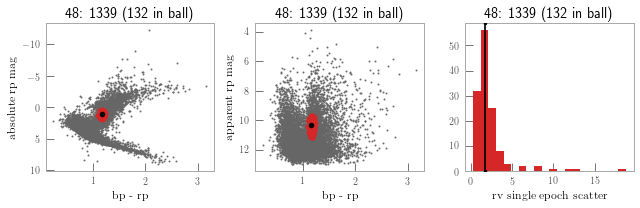

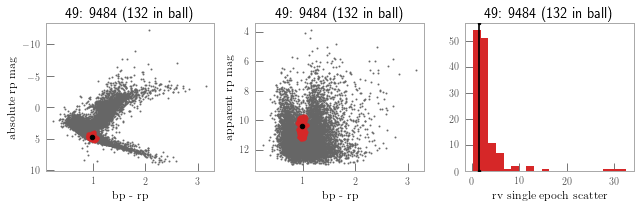

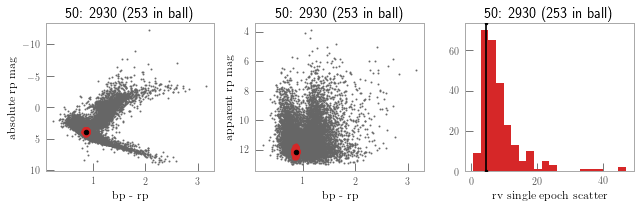

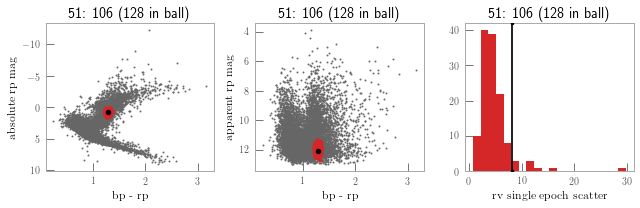

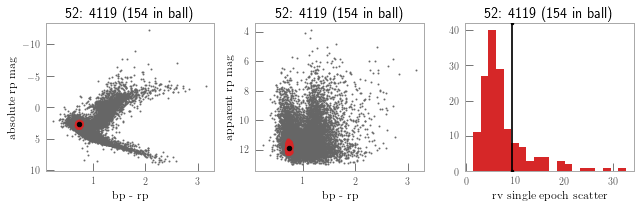

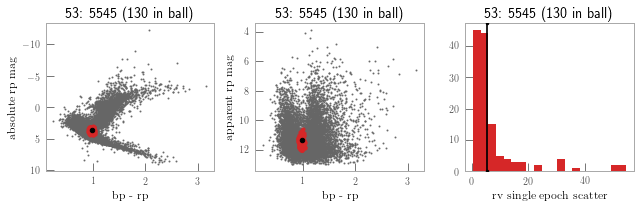

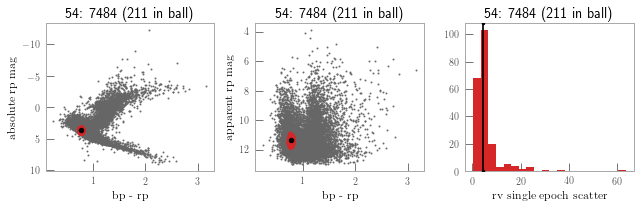

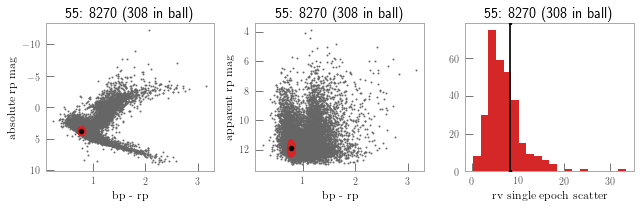

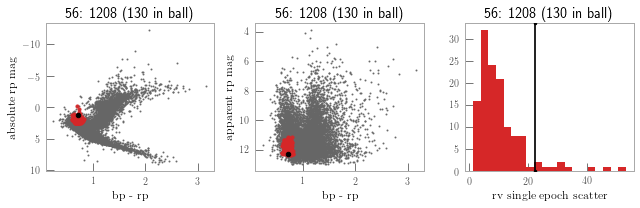

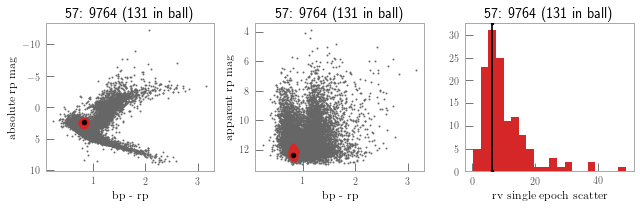

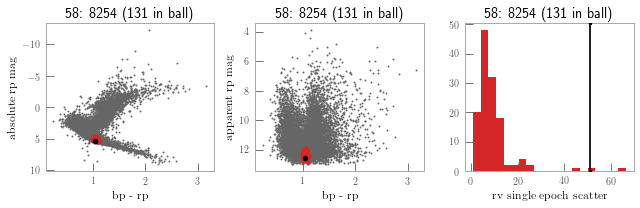

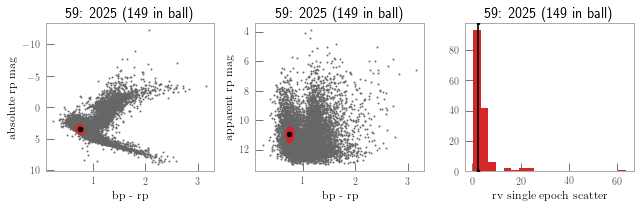

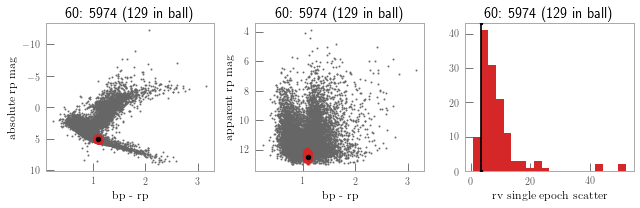

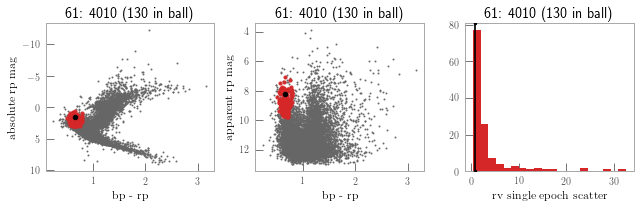

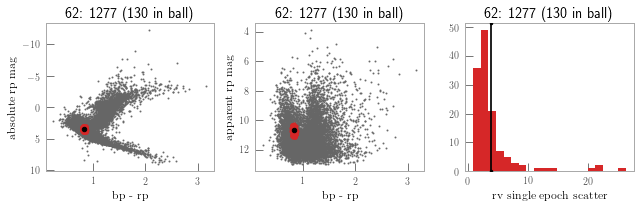

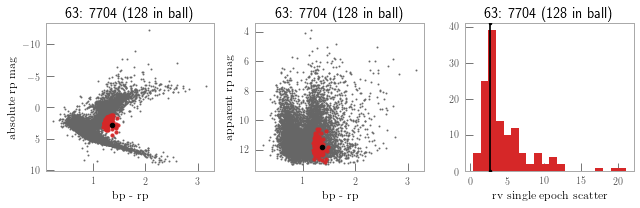

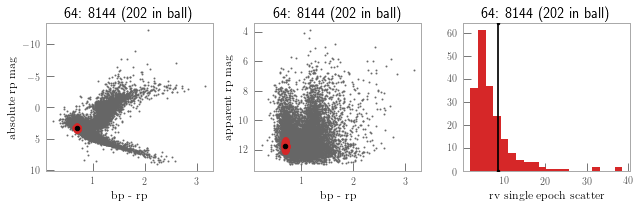

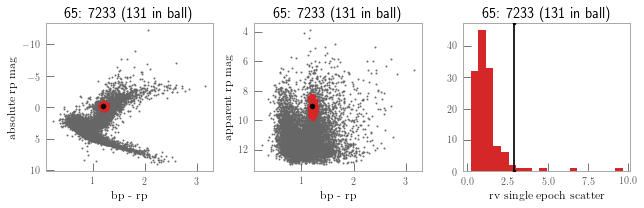

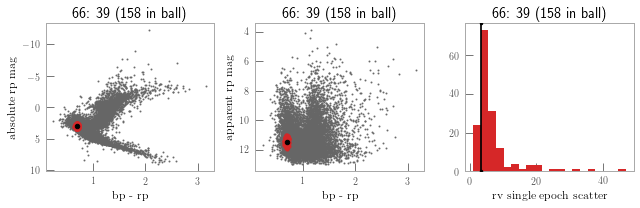

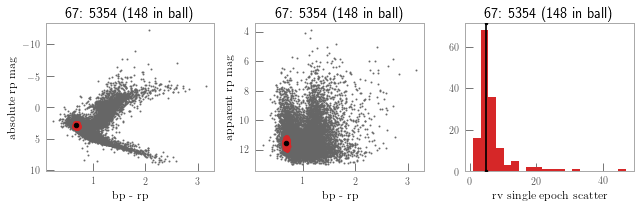

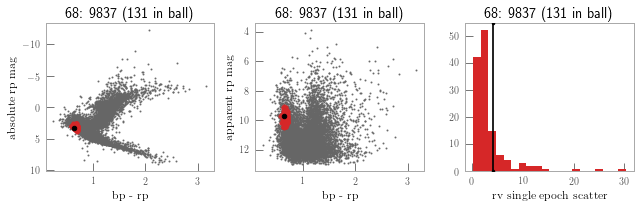

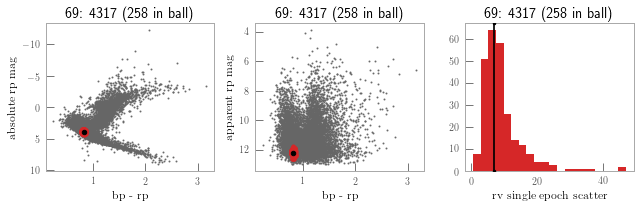

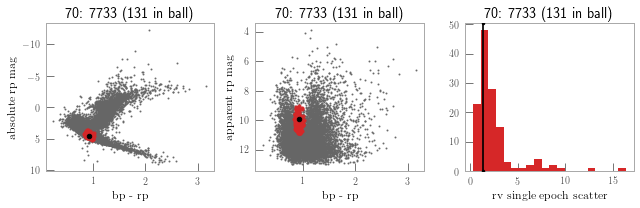

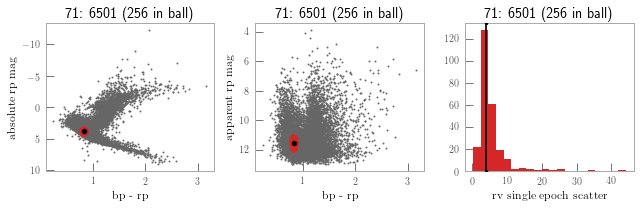

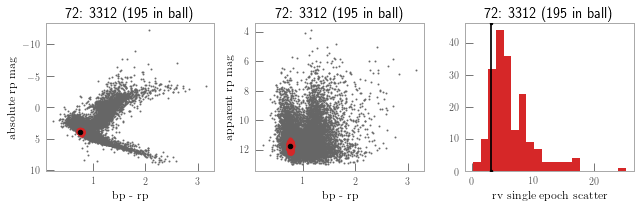

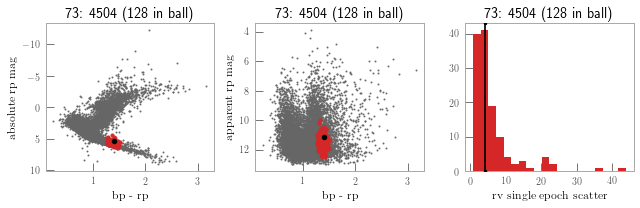

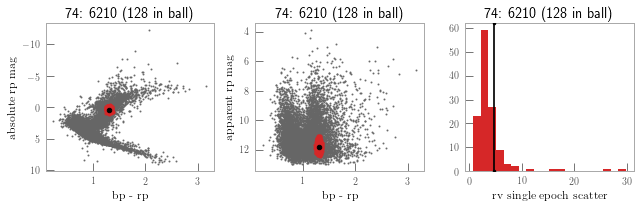

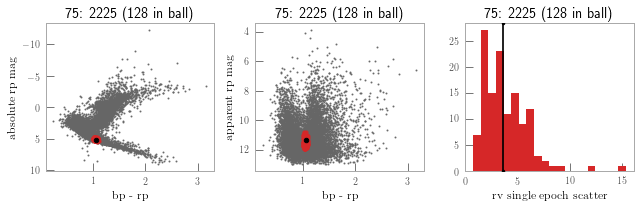

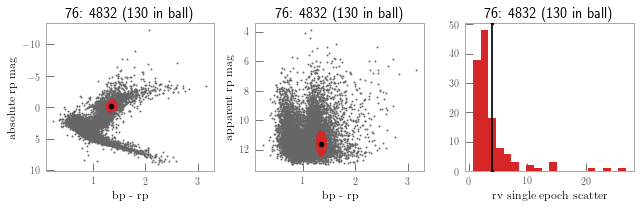

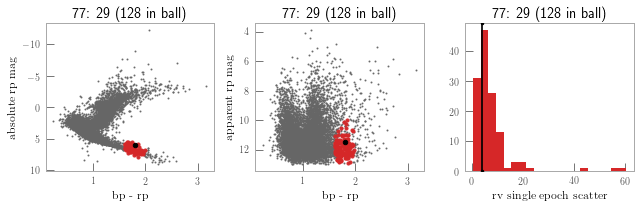

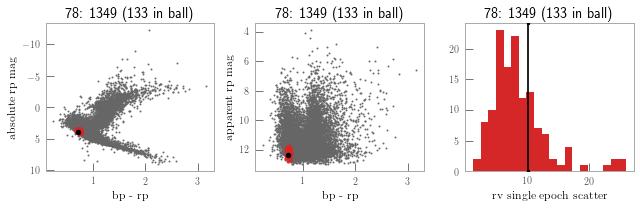

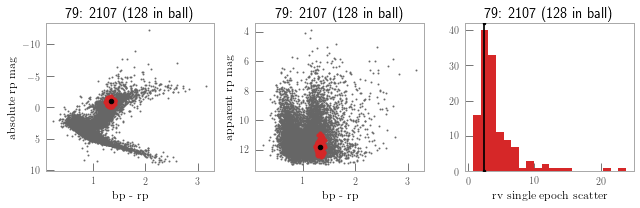

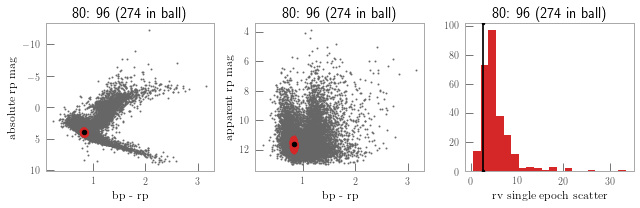

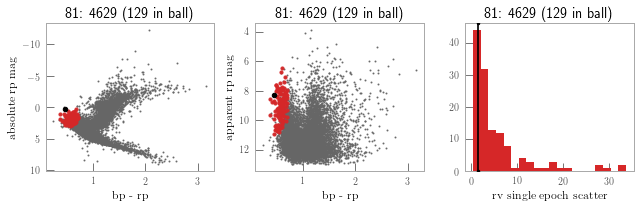

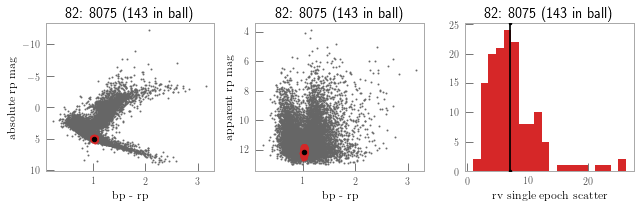

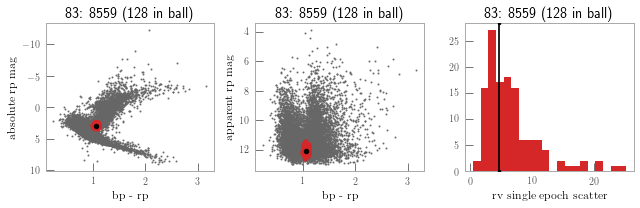

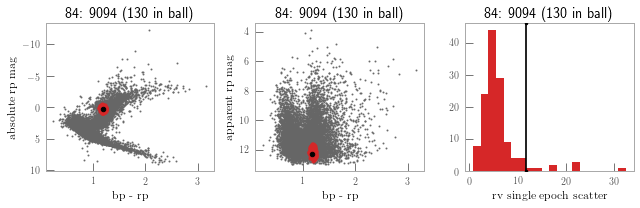

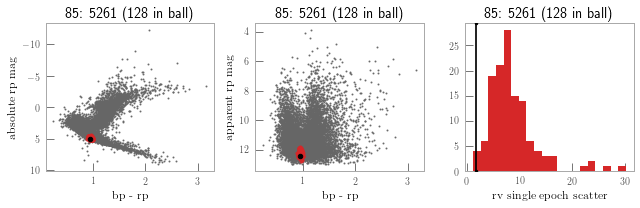

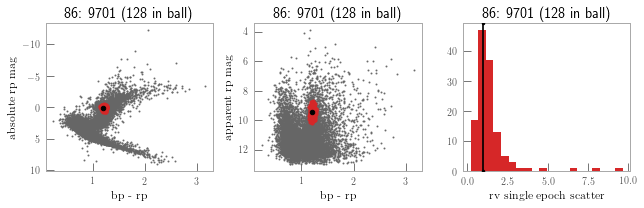

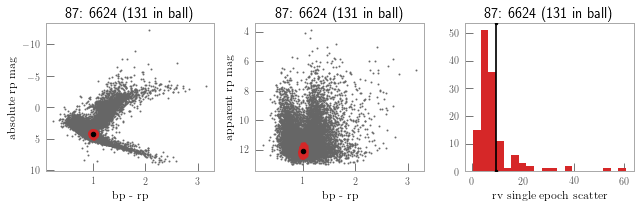

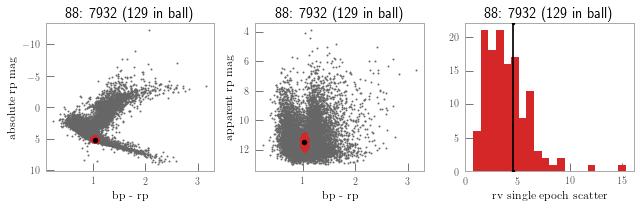

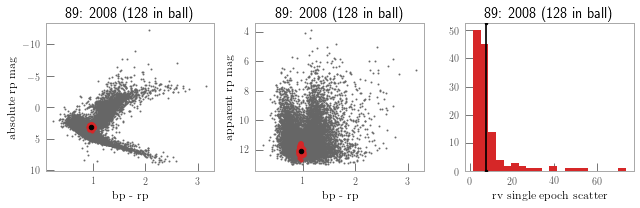

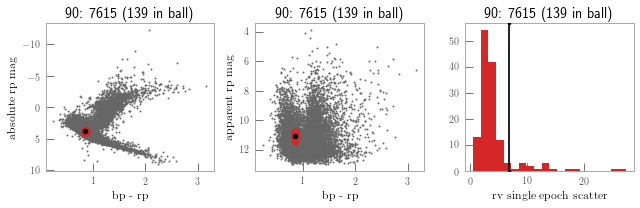

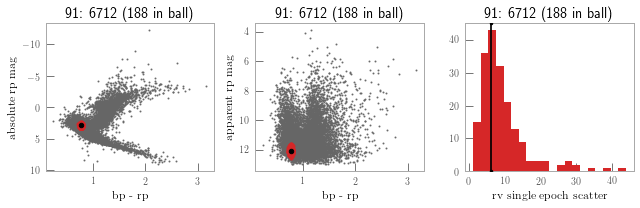

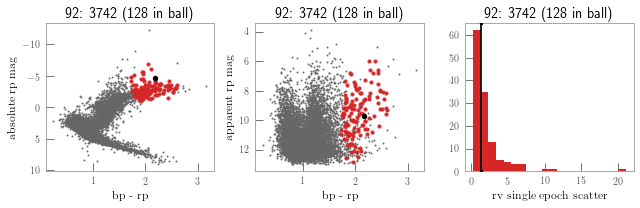

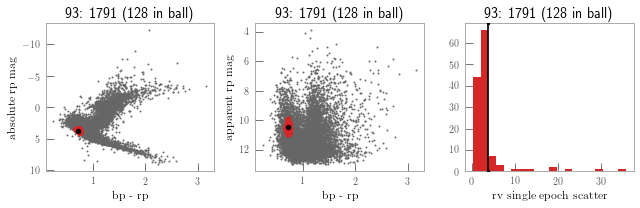

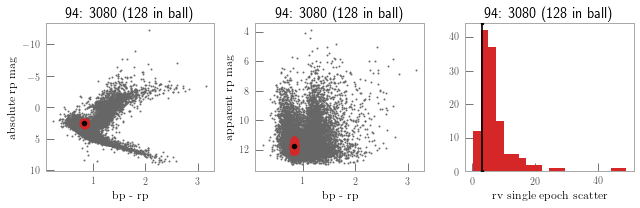

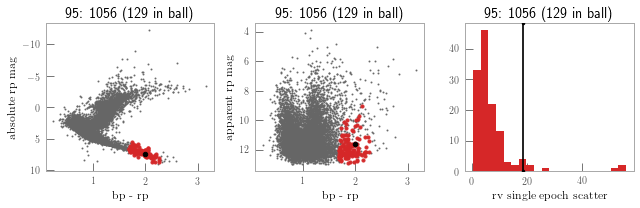

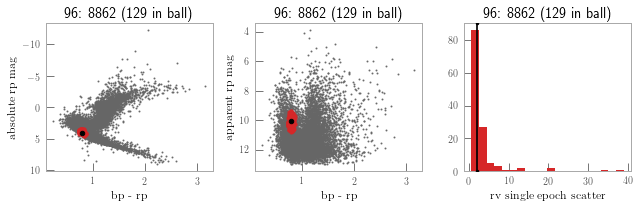

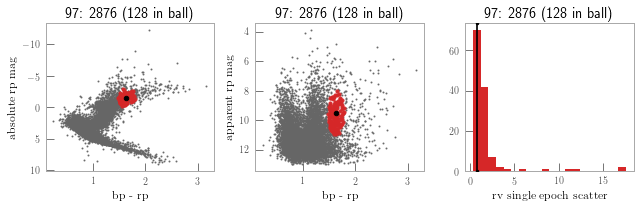

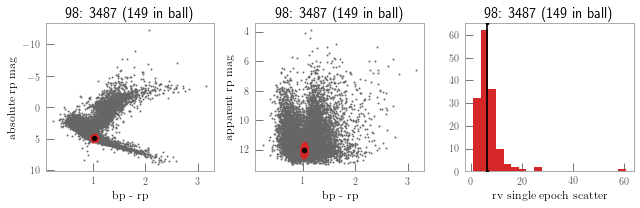

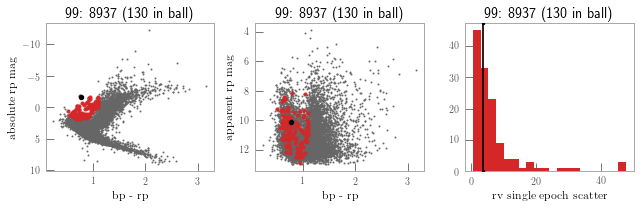

In [15]:
np.random.seed(42)

P = 100 # number of plots

scatter_bg_kwds = dict(s=1, c="#666666", alpha=0.9)
scatter_ball_kwds = dict(s=10, c="tab:red", zorder=5, alpha=0.9)
scatter_point_kwds = dict(s=20, c="#000000", zorder=10, alpha=1)
hist_kwds = dict(facecolor="tab:red", bins=20)
axvline_kwds = dict(zorder=10, c="#000000")

matplotlib.rcParams["figure.max_open_warning"] = 10*P # shh

for i, index in enumerate(np.random.choice(N, P, replace=False)):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    
    axes[0].scatter(X.T[0], X.T[1], **scatter_bg_kwds)
    
    nearby = npm.query_around_point(kdt, X[index], **query_kwds)
    axes[0].scatter(X[nearby, 0], X[nearby, 1], **scatter_ball_kwds)
    axes[0].scatter(X[[index], 0], X[[index], 1], **scatter_point_kwds)
    
    axes[0].set_xlabel(r"\textrm{bp - rp}")
    axes[0].set_ylabel(r"\textrm{absolute rp mag}")
    axes[0].set_ylim(axes[0].get_ylim()[::-1])
    
    axes[1].scatter(X.T[0], X.T[2], **scatter_bg_kwds)
    axes[1].scatter(X[nearby, 0], X[nearby, 2], **scatter_ball_kwds)
    axes[1].scatter(X[[index], 0], X[[index], 2], **scatter_point_kwds)
    axes[1].set_xlabel(r"\textrm{bp - rp}")
    axes[1].set_ylabel(r"\textrm{apparent rp mag}")
    axes[1].set_ylim(axes[1].get_ylim()[::-1])
    
    y = predictors[nearby].flatten()
    axes[2].hist(y[np.isfinite(y)], **hist_kwds)
    axes[2].axvline(predictors[index], **axvline_kwds)
    axes[2].set_xlabel(r"\textrm{rv single epoch scatter}")
    
    for ax in axes:
        ax.set_title("{}: {} ({} in ball)".format(i, index, nearby.size))
    
    fig.tight_layout()